# Regresión lineal: predecir los gastos médicos de pacientes
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos.


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [ ]:
pip install --upgrade pip setuptools==57.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
arviz 0.15.1 requires setuptools>=60.0.0, but you have setuptools

In [ ]:
!pip install regressors

  Preparing metadata (setup.py) ... done
  Created wheel for regressors: filename=regressors-0.0.3-py2.py3-none-any.whl size=12399 sha256=0de885036e936831ac50cf3bc920379717912a1d22e5260333e8d036dc89b1f2
  Stored in directory: /root/.cache/pip/wheels/85/e8/ec/b8fe5e2d41af2f4760b0d8ce1ae8f01c78df5d1b0883dee2fe
Successfully built regressors


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [ ]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


(1338, 7)


<Axes: >

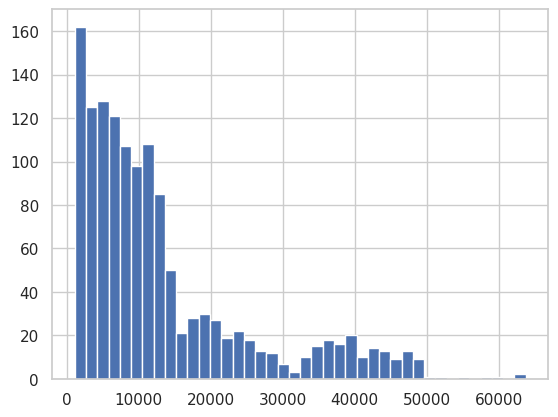

In [ ]:
print(df.shape)
df.charges.hist(bins=40)

In [ ]:
df[df.charges>50000]
df = df[df.charges<50000]
df.shape

(1331, 7)

## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

<Axes: >

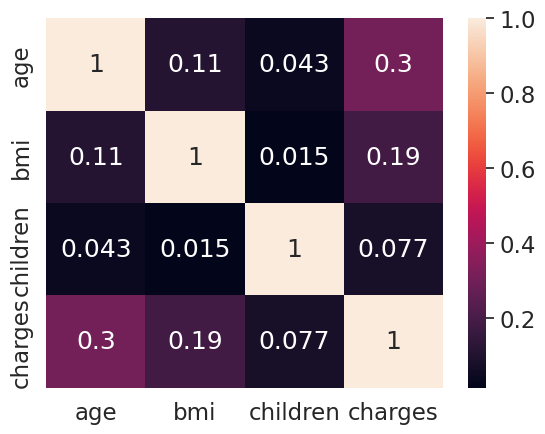

In [ ]:
import numpy as np
numeric_cols = ['age','bmi','children','charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio.

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan.

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas.

Ahora la verás en acción

In [ ]:
 df = pd.get_dummies(df,columns=['sex','smoker','region']) #para hacer el oneHotEncoding
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


## Creando modelos
Primero se usará un modelo con todas las variables.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


In [ ]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X=df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [ ]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2: ", r2.round(4))
print("mse: ", mse.round(4))


r2:  0.7467
mse:  0.2439


El siguiente código muestra un resumen general de los resultados.

In [ ]:
y_test = y_test.reshape(-1)

print("===========Summary============")
stats.summary(model,X_test,y_test,X_cols)

===========Summary============
Residuals:
    Min      1Q  Median     3Q    Max
-2.0668 -0.0971  0.1037 0.2623 0.9423


Coefficients:
                      Estimate                  Std. Error                     t value   p value
_intercept        1.197800e-02  2.724700e-02+0.000000e+00j  4.396000e-01+0.000000e+00j  0.660512
bmi               1.690180e-01  4.639200e-02-0.000000e+00j  3.643200e+00+0.000000e+00j  0.000312
sex_female        3.603017e+12 -2.991838e+02+1.464666e+06j -5.024897e+02-2.459958e+06j  0.000000
smoker_yes        8.539361e+12  7.479798e+07+2.640527e+00j  1.141657e+05-4.000000e-03j  0.000000
sex_male          3.603017e+12 -3.028340e+02+1.464517e+06j -5.087238e+02-2.460208e+06j  0.000000
smoker_no         8.539361e+12  7.479798e+07+2.640527e+00j  1.141657e+05-4.000000e-03j  0.000000
region_southeast  5.779372e+11  9.515285e+02+1.939445e+05j  1.461965e+04-2.979838e+06j  0.000000
region_southwest  5.567958e+11  8.831894e+02+1.800148e+05j  1.517480e+04-3.092982e+06j  0.

In [ ]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

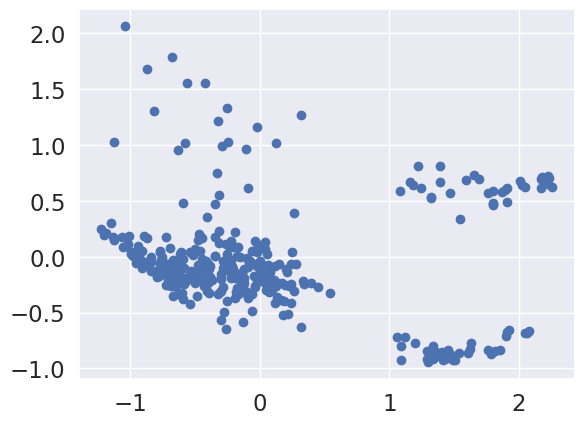

In [ ]:
import matplotlib.pyplot as plt
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [ ]:
df_second = df.copy()
df_second['age2'] = df_second.age**2
df_second['sobrepreso'] = (df_second.bmi >= 30).astype(int)


In [ ]:
df_second['sobrepeso*fumador'] = df_second.sobrepreso * df_second.smoker_yes

In [ ]:
df_second.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age2,sobrepreso,sobrepeso*fumador
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1,361,0,0
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0,324,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0,784,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0,1089,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0,1024,0,0


Analizando el segundo modelo

In [ ]:
X_cols = list(set(df_second.columns)-set(['charges']))
y_col = ['charges']

X=df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2: ", r2.round(4))
print("mse: ", mse.round(4))

r2:  0.9012
mse:  0.1152


In [ ]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [ ]:
y_test = y_test.reshape(-1)

print("===========Summary============")
stats.summary(model,X_test,y_test,X_cols)

===========Summary============
Residuals:
    Min     1Q  Median    3Q    Max
-1.6178 0.0649  0.1124 0.145 1.4279


Coefficients:
                       Estimate                  Std. Error                     t value   p value
_intercept         7.405000e-03  1.846400e-02+0.000000e+00j  4.010000e-01+0.000000e+00j  0.688650
bmi                4.954700e-02  3.128968e+05-7.165985e+03j  0.000000e+00+0.000000e+00j  1.000000
sex_female         1.993636e+12  7.238978e+06+6.857613e+12j  0.000000e+00-2.907000e-01j  0.771448
smoker_yes        -1.652989e+12  3.008976e+05+1.675848e+14j -0.000000e+00+9.900000e-03j  0.992136
sex_male           1.993636e+12  7.202745e+06+6.857613e+12j  0.000000e+00-2.907000e-01j  0.771448
age2               3.729860e-01  9.638100e-02+0.000000e+00j  3.869900e+00-0.000000e+00j  0.000131
smoker_no         -1.652989e+12  2.901407e+05+1.675848e+14j -0.000000e+00+9.900000e-03j  0.992136
region_southeast   5.783713e+12  4.535038e+03+1.498527e+05j  1.166974e+06-3.856068e+07

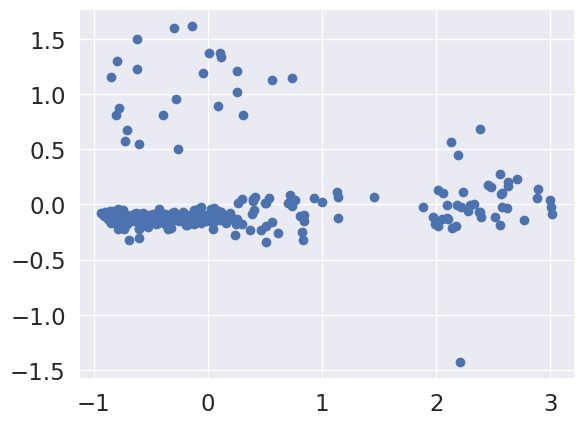

In [ ]:
import matplotlib.pyplot as plt
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.show()

MEJORA DEL MODELO

#Tomaré las variables que impacten al modelo, básandome en el pvalor.


In [ ]:
X_cols = ['children', 'sobrepeso*fumador','age2', 'smoker_yes', 'region_northwest', 'region_northeast', 'region_southwest', 'region_southeast' ]
y_col = ['charges']

X=df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print("r2: ", r2.round(4))
print("mse: ", mse.round(4))

r2:  0.8731
mse:  0.1283


In [ ]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [ ]:
y_test = y_test.reshape(-1)

print("===========Summary============")
stats.summary(model,X_test,y_test,X_cols)

===========Summary============
Residuals:
    Min     1Q  Median     3Q   Max
-2.0491 0.0705   0.112 0.1447 0.296


Coefficients:
                       Estimate               Std. Error                     t value   p value
_intercept         1.361000e-03   0.01983200+0.00000000j  6.860000e-02-0.000000e+00j  0.945342
children           7.554200e-02   0.01911900+0.00000000j  3.951100e+00-0.000000e+00j  0.000095
sobrepeso*fumador  4.922000e-01   0.02402100+0.00000000j  2.049050e+01-0.000000e+00j  0.000000
age2               3.261420e-01   0.01994900+0.00000000j  1.634890e+01-0.000000e+00j  0.000000
smoker_yes         4.590090e-01   0.02381800+0.00000000j  1.927190e+01-0.000000e+00j  0.000000
region_northwest   6.669732e+11  0.013464+137936.840547j  4.720000e-01-4.835352e+06j  0.000000
region_northeast   6.669732e+11  0.013576+137936.840547j  4.759000e-01-4.835352e+06j  0.000000
region_southwest   6.669732e+11  0.013341+137936.840547j  4.676000e-01-4.835352e+06j  0.000000
region_southeas